In [ ]:
from google.colab import files
upload = files.upload()

Saving NGTL_capability.csv to NGTL_capability.csv


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler ,LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix ,classification_report
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def metrics(y_pred, y_truth):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error)
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)

    R2 = r2_score(y_truth, y_pred)
    print('R2 score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

In [ ]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted Gas Flow MM values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/NGTL_capability.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/gas_day_summary_report_data.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/wgat_contract_demand.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/egat_contract_demand.csv')
df5 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/historical_gas_price.csv')
df6 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/hist_fx_rate.csv')
df7 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/fx_fwds.csv')
df8 = pd.read_csv('/content/drive/MyDrive/Drive/Enmax/forward_price_strip - Copy.csv')

In [ ]:
df1["DEL_DATE"] = pd.to_datetime(df1["DEL_DATE"])
df2["DEL_DATE"] = pd.to_datetime(df2["DEL_DATE"])
df3["DEL_DATE"] = pd.to_datetime(df3["DEL_DATE"])
df4["DEL_DATE"] = pd.to_datetime(df4["DEL_DATE"])
df5["EFFECTIVE_START"] = pd.to_datetime(df5["EFFECTIVE_START"])
df6["OPR_DATE"] = pd.to_datetime(df6["OPR_DATE"])
df7["MATURITY"] = pd.to_datetime(df7["MATURITY"])
df8["STRIP"] = pd.to_datetime(df8["STRIP"])

**Handling Null Values (Weekend days) in Historical FX table using the FFILL**

In [ ]:
df1.index = df1['DEL_DATE']

In [ ]:
df1.index

DatetimeIndex(['2018-07-13', '2018-07-13', '2018-07-13', '2018-07-13',
               '2018-07-13', '2018-07-13', '2018-07-13', '2018-07-13',
               '2018-07-14', '2018-07-14',
               ...
               '2024-11-25', '2024-11-25', '2024-11-26', '2024-11-26',
               '2024-11-26', '2024-11-26', '2024-11-26', '2024-11-26',
               '2024-11-26', '2024-11-26'],
              dtype='datetime64[ns]', name='DEL_DATE', length=18632, freq=None)

In [ ]:
df_date = pd.DataFrame(pd.date_range(start="2017-04-18",end="2022-03-01"),columns = ['date'])
df_date_1 = pd.merge(df_date,df6,left_on='date', right_on='OPR_DATE',how='left')
df_date_1.drop(['OPR_DATE','CURRENCY_ISO','DATE_INSERTED','Unnamed: 4'], axis = 1, inplace = True)
df_date_1.fillna(method='ffill', inplace=True)

In [ ]:
df_date_1

,date,TRADE_DATE,HUB,PRODUCT,STRIP,CONTRACT_MONTH,CONTRACT_YEAR,CONTRACT,CONTRACT_TYPE,SETTLEMENT_PRICE,NET_CHANGE,EXPIRY_DATE,PRODUCT_ID,PUBLISH_DATE,DATE_INSERTED
date,,,,,,,,,,,,,,,
2022-04-01,2022-04-01,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2022-04-01,4.0,2022.0,XAJ,F,4.4480,0.1685,2022-03-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02
2022-04-02,2022-04-02,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2022-04-01,4.0,2022.0,XAJ,F,4.4480,0.1685,2022-03-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02
2022-04-03,2022-04-03,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2022-04-01,4.0,2022.0,XAJ,F,4.4480,0.1685,2022-03-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02
2022-04-04,2022-04-04,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2022-04-01,4.0,2022.0,XAJ,F,4.4480,0.1685,2022-03-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02
2022-04-05,2022-04-05,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2022-04-01,4.0,2022.0,XAJ,F,4.4480,0.1685,2022-03-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25,2023-02-25,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2023-02-01,2.0,2023.0,XAJ,F,4.7645,0.1420,2023-01-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02
2023-02-26,2023-02-26,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2023-02-01,2.0,2023.0,XAJ,F,4.7645,0.1420,2023-01-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02
2023-02-27,2023-02-27,2022-03-01 0:00,Union-Dawn,"NGX Phys FUT, FP (US/MM)",2023-02-01,2.0,2023.0,XAJ,F,4.7645,0.1420,2023-01-31 0:00,1902-07-18 0:00,2022-03-01 0:00,2022-03-01 16:02


**Handling the FX rate values that fall between dates using FFILL based on the Maturity date**

In [ ]:
df_date = pd.DataFrame(pd.date_range(start="2022-03-01",end="2023-03-01"),columns = ['date'])
df_date_2 = pd.merge(df_date,df7,left_on='date', right_on='MATURITY',how='left')
df_date_2.drop(['OPR_DATE','MATURITY'], axis = 1, inplace = True)
df_date_2.fillna(method='ffill', inplace=True)

In [ ]:
df_date_2

,date,MATURITY_PRICE
0,2022-03-01,1.274150
1,2022-03-02,1.274150
2,2022-03-03,1.274150
3,2022-03-04,1.274150
4,2022-03-05,1.274150
...,...,...
361,2023-02-25,1.275578
362,2023-02-26,1.275578
363,2023-02-27,1.275578
364,2023-02-28,1.275578


In [ ]:
df_date_2 = df_date_2.iloc[1: , :]
df_date_2.columns = ['date', 'USD_MID']

In [ ]:
df_FX = pd.concat([df_date_1, df_date_2], axis=0)

In [ ]:
df_FX.index = df_FX['date']
df_FX

,date,USD_MID
date,,
2017-04-18,2017-04-18,1.338100
2017-04-19,2017-04-19,1.346900
2017-04-20,2017-04-20,1.348000
2017-04-21,2017-04-21,1.350300
2017-04-22,2017-04-22,1.350300
...,...,...
2023-02-25,2023-02-25,1.275578
2023-02-26,2023-02-26,1.275578
2023-02-27,2023-02-27,1.275578


In [ ]:
df_FX.loc[df_FX.date == '2022-03-01']

,date,USD_MID
date,,
2022-03-01,2022-03-01,1.271


**Historical Gas prices Cleaning**

In [ ]:
df_date = pd.DataFrame(df5['EFFECTIVE_START'].unique(), columns = ['date'])
dff = pd.DataFrame()
for i , value in enumerate(df5['INDEX_NAME'].unique()):
  i = pd.DataFrame()
  i[value] = df5.loc[df5.INDEX_NAME == value]['INDEX_PRICE']
  i['date'] = df5.loc[df5.INDEX_NAME == value]['EFFECTIVE_START']
  # i.reset_index(drop=True, inplace=True)
  dfff = pd.merge(df_date,i,on='date',how='left')
  # dfff.drop('date', inplace = True)
  dff = pd.concat([dff, dfff], axis=1)
  # dff.reset_index(drop=True, inplace=True)
dff.index = df_date['date'].unique()
dff.fillna(0, inplace=True)
dff.drop('date', axis = 1, inplace = True)
df_hist = dff.copy()

In [ ]:
df_hist

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,Empress_DA
2016-01-01,2.6400,2.4764,1.7269,0.000,0.0000
2016-01-02,2.6400,2.4764,1.6464,0.000,0.0000
2016-01-03,2.6400,2.4764,1.7236,0.000,0.0000
2016-01-04,2.6400,2.4764,1.7647,0.000,0.0000
2016-01-05,2.5185,2.5386,1.7262,0.000,0.0000
...,...,...,...,...,...
2022-04-26,4.0761,4.3815,3.7278,5.175,0.0986
2022-04-27,4.0761,4.3815,3.7278,5.175,0.0986
2022-04-28,4.0761,4.3815,3.7278,5.175,0.0986
2022-04-29,4.0761,4.3815,3.7278,5.175,0.0986


**NGTL Capability table Cleaning**

In [ ]:
dff = pd.DataFrame()

for i , value in enumerate(df1['TABLE'].unique()):
  i = pd.DataFrame()
  i[value] = df1.loc[df1.TABLE == value]['CAPABILITY']
  i.reset_index(drop=True, inplace=True)
  dff = pd.concat([i, dff], axis=1)
  # dff.reset_index(drop=True, inplace=True)

dff.index = df1['DEL_DATE'].unique()
dff.fillna(0, inplace=True)
df_NGTL = dff.copy()

In [ ]:
df_NGTL

,EGAT,OSDA,NEDA,LCLR,FHZ9,LCLD,USJR,WGAT
2018-07-13,4765.629854,3071.183684,0.0,0.0,0.0,0.0,10060.77414,2329.863484
2018-07-14,4765.629854,3071.183684,0.0,0.0,0.0,0.0,10060.77414,2329.863484
2018-07-15,4765.629854,3071.183684,0.0,0.0,0.0,0.0,10060.77414,2329.863484
2018-07-16,4765.629854,3071.183684,0.0,0.0,0.0,0.0,10060.77414,2329.863484
2018-07-17,4765.629854,3071.183684,0.0,0.0,0.0,0.0,10060.77414,2329.863484
...,...,...,...,...,...,...,...,...
2024-11-22,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836
2024-11-23,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836
2024-11-24,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836
2024-11-25,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836


In [ ]:
df2.index = df2['DEL_DATE']
df3.index = df3['DEL_DATE']
df4.index = df4['DEL_DATE']

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2521 entries, 2018-01-01 to 2024-11-25
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DEL_DATE         2521 non-null   datetime64[ns]
 1   EFFECTIVE_DATE   2521 non-null   object        
 2   CONTRACT_DEMAND  2521 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 78.8+ KB


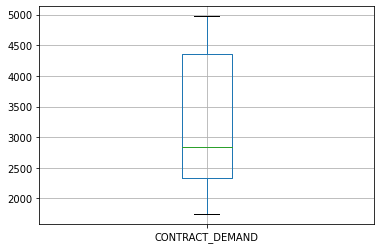

In [ ]:
df4.boxplot(column='CONTRACT_DEMAND')

**EGAT demand data is good, No outlier and no Null values!**
The GasFlow values can also be expected to depend on it’s previous lagged values because the gas consumption of a region shouldn’t be expected to change much in the next few hours except for any unexpected or unfortunate events.

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2522 entries, 2018-01-01 to 2024-11-26
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DEL_DATE         2522 non-null   datetime64[ns]
 1   EFFECTIVE_DATE   2522 non-null   object        
 2   CONTRACT_DEMAND  2494 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 78.8+ KB


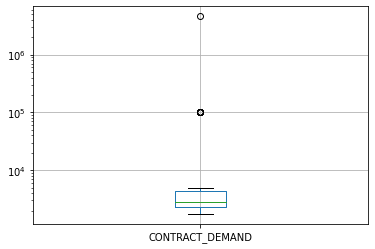

In [ ]:
df3.boxplot(column='CONTRACT_DEMAND')
plt.yscale('log')
plt.show()

**WGAT looks messy, we have Null values and outliers!**

In [ ]:
x = df3['CONTRACT_DEMAND'].dropna()
iqr = np.percentile(x,75) - np.percentile(x,25)

In [ ]:
outliers_mask = (x > np.percentile(x,75) + 1.5*iqr) | (x < np.percentile(x,25) - 1.5*iqr)

In [ ]:
x[outliers_mask]

DEL_DATE
2021-08-14      99999.0
2021-08-15      99999.0
2021-08-16      99999.0
2021-08-17      99999.0
2021-08-18      99999.0
2021-08-19      99999.0
2021-08-20      99999.0
2021-08-21      99999.0
2023-02-13    4596333.0
Name: CONTRACT_DEMAND, dtype: float64

**As we see, we have outliers and NULL values in WGAT dataset, let's take care of them**
The Demands and their prices are set monthly as it appears so we will fill the gaps based on each month's demand

In [ ]:
df3.head(40)

In [ ]:
df3['month'] = pd.to_numeric(df3.index.month)
df3['year'] = pd.to_numeric(df3.index.year)

In [ ]:
df3['CONTRACT_DEMAND'] = df3['CONTRACT_DEMAND'].replace([99999,4596333], None)
# df3.fillna(method='ffill', inplace=True)
df3['CONTRACT_DEMAND'] = df3.groupby(['year','month'])['CONTRACT_DEMAND'].apply(lambda x:x.fillna(x.mean()))

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2522 entries, 0 to 2521
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DEL_DATE         2522 non-null   datetime64[ns]
 1   EFFECTIVE_DATE   2522 non-null   object        
 2   CONTRACT_DEMAND  2494 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.2+ KB


In [ ]:
df_NGTL_f = df_NGTL[df_NGTL.index <= '2022-03-01']
df_hist_f = df_hist[(df_hist.index <= '2022-03-01') & (df_hist.index >= '2018-07-13')]
df_FX_f = df_FX[(df_FX.index <= '2022-03-01') & (df_FX.index >='2018-07-13')]
df2_f = df2[df2.index >= '2018-07-13']
df3_f = df3[(df3.index >= '2018-07-13') & (df3.index <= '2022-03-01')]
df4_f = df4[(df4.index >= '2018-07-13') & (df4.index <= '2022-03-01')]

In [ ]:
from functools import reduce
dfs = [df_hist_f,df_NGTL_f,df_FX_f,df2_f,df3_f,df4_f]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)

In [ ]:
df_final.columns

Index(['Malin_DA', 'Union_Dawn_DA', 'AB_NIT_SD_2A', 'Ventura_DA', 'Empress_DA',
       'EGAT_x', 'OSDA', 'NEDA', 'LCLR', 'FHZ9', 'LCLD', 'USJR', 'WGAT',
       'date', 'USD_MID', 'DEL_DATE_x', 'AB_BC_BORDER', 'GORDONDALE_BORDER',
       'GROUNDBIRCH_EAST', 'OTHER_BORDERS', 'TOTAL_EXPORT_DELIVERIES_GROSS',
       'INTRAPROVINCIAL', 'NGTL_FIELD_RECEIPTS', 'TOTAL_NET_STORAGE',
       'END_DAY_PROJ_LINEPACK', 'LINEPACK_RATE_CHANGE', 'LINEPACK_CHANGE',
       'TOTAL_T_ACCT', 'TOTAL_Z_ACCT', 'EGAT_y', 'DEL_DATE_y',
       'EFFECTIVE_DATE_x', 'CONTRACT_DEMAND_x', 'month', 'year', 'DEL_DATE',
       'EFFECTIVE_DATE_y', 'CONTRACT_DEMAND_y'],
      dtype='object')

In [ ]:
df_final.drop(['DEL_DATE_y','DEL_DATE','EFFECTIVE_DATE_y','EFFECTIVE_DATE_x'], axis = 1, inplace = True)

In [ ]:
df_final

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,Empress_DA,EGAT_x,OSDA,NEDA,LCLR,FHZ9,...,END_DAY_PROJ_LINEPACK,LINEPACK_RATE_CHANGE,LINEPACK_CHANGE,TOTAL_T_ACCT,TOTAL_Z_ACCT,EGAT_y,CONTRACT_DEMAND_x,month,year,CONTRACT_DEMAND_y
2018-07-13,2.5538,2.7457,1.1011,1.8300,1.0288,4765.629854,3071.183684,0.0,0.0,0.0,...,17415,-238,400,-430.3,338.3,4324,1846.047420,7,2018,1846.047420
2018-07-14,2.5604,2.7123,0.7502,1.8300,1.2827,4765.629854,3071.183684,0.0,0.0,0.0,...,17436,46,22,99.6,279.8,4223,1846.047420,7,2018,1846.047420
2018-07-15,2.5604,2.7123,0.7630,1.8300,1.2827,4765.629854,3071.183684,0.0,0.0,0.0,...,17467,-47,31,-46.0,310.9,4254,1846.047420,7,2018,1846.047420
2018-07-16,2.5604,2.7123,0.7082,1.5500,1.2827,4765.629854,3071.183684,0.0,0.0,0.0,...,17202,-260,-265,32.3,220.4,4305,1846.047420,7,2018,1846.047420
2018-07-17,2.5482,2.7431,0.9571,1.6267,1.5747,4765.629854,3071.183684,0.0,0.0,0.0,...,17332,-139,130,-159.9,452.6,4170,1846.047420,7,2018,1846.047420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,5.4240,4.7965,3.7896,5.1750,0.2048,5118.639473,3282.989455,0.0,0.0,0.0,...,18928,-221,-242,430.6,-4.2,4959,4972.820197,2,2022,4972.820197
2022-02-26,4.3533,4.4837,3.7532,5.1750,0.2136,5118.639473,3282.989455,0.0,0.0,0.0,...,19263,449,335,970.5,17.1,4859,4972.820197,2,2022,4972.820197
2022-02-27,4.3533,4.4837,3.6640,5.1750,0.2136,5118.639473,3282.989455,0.0,0.0,0.0,...,19269,-140,6,361.2,273.0,4825,4972.820197,2,2022,4972.820197
2022-02-28,4.3533,4.4837,3.7244,5.1750,0.2136,5118.639473,3282.989455,0.0,0.0,0.0,...,19356,362,87,442.4,450.6,4746,4972.820197,2,2022,4972.820197


In [ ]:
df_final.info()

***Now we have cleaned the data, let's analyse it and make visualizations.***

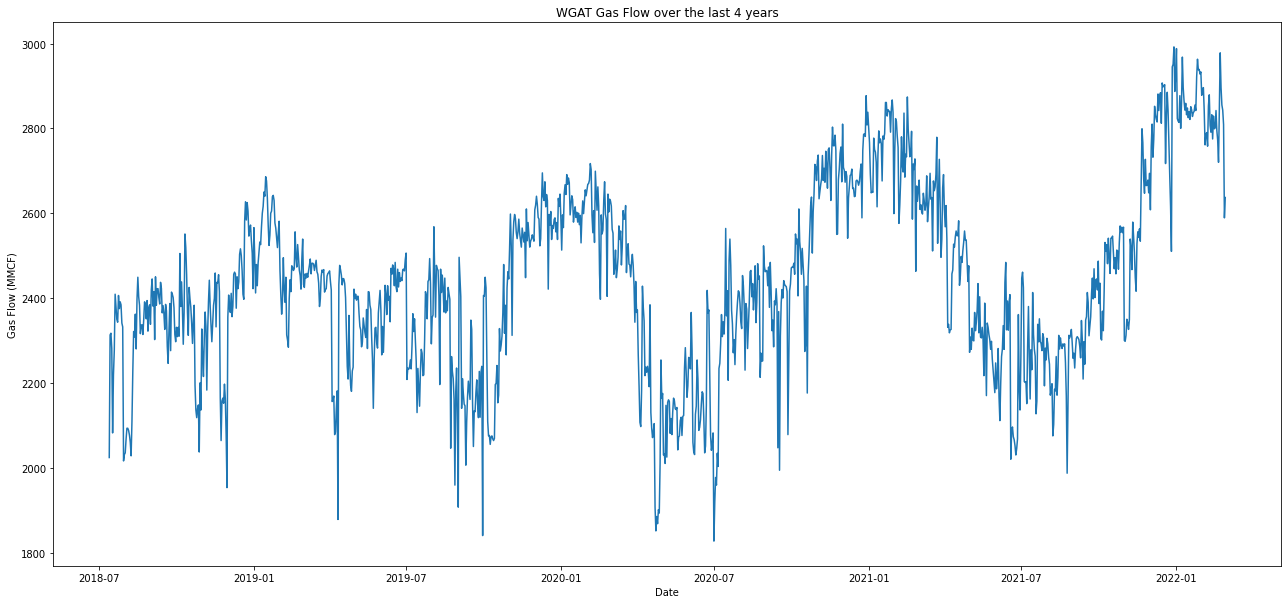

In [ ]:
plt.figure(figsize=(22,10))
plt.plot(df_final.index,df_final.AB_BC_BORDER)

plt.title("WGAT Gas Flow over the last 4 years")
plt.xlabel("Date")
plt.ylabel("Gas Flow (MMCF)")
plt.show()

In [ ]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    
    # Plot the ACF of ts
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)

    # Plot the PACF of ts
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

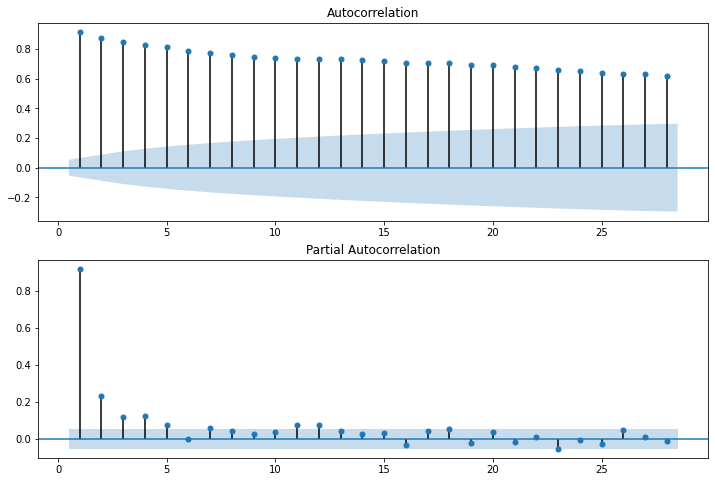

In [ ]:
dfacf = []
dfacf = df_final['AB_BC_BORDER']
lags = 28
acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

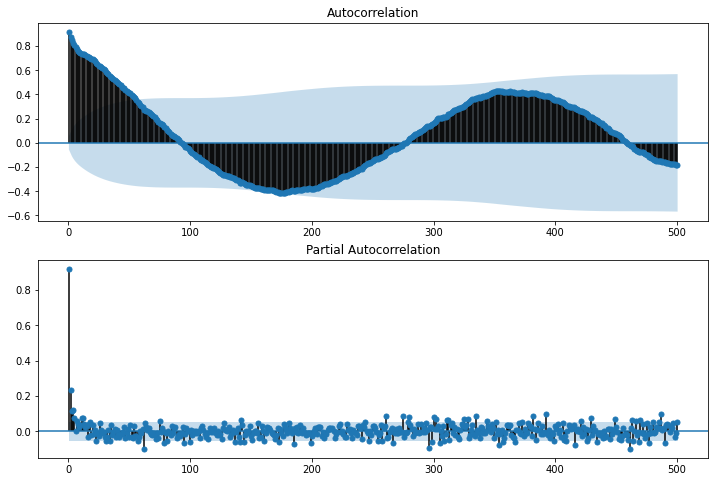

In [ ]:
dfacf = []
dfacf = df_final['AB_BC_BORDER']
lags = 500
acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

**We have many significant values in both ACF and PACF and a yearly Seasonality can easily be seen in the ACF plot, based on this neither MA or AR or ARIMA models would be appropriate to use for prediction.This is a common pitfall of the SARIMAX models.**

In [ ]:
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

check_adfuller(df_final.AB_BC_BORDER)

Test statistic:  -2.696641640614366
p-value:  0.07462121702525416
Critical Values: {'1%': -3.4353288002925315, '5%': -2.863738738939919, '10%': -2.5679406189198177}


**So as you see the P-Value is a little above 0.05 so we could say we can reject the null hypothesis and say our data is not stationary.**

***
• Upstream James River (USJR) – Receipt

• West Gate (WGAT) – Delivery

• East Gate (EGAT) – Delivery

• North East Delivery Area (NEDA) – Delivery

• Oil Sands Delivery Area (OSDA) – Delivery


In [ ]:
corr = df_final.corr()
corr.style.background_gradient(cmap='coolwarm')

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,Empress_DA,EGAT_x,OSDA,NEDA,LCLR,FHZ9,LCLD,USJR,WGAT,USD_MID,AB_BC_BORDER,GORDONDALE_BORDER,GROUNDBIRCH_EAST,OTHER_BORDERS,TOTAL_EXPORT_DELIVERIES_GROSS,INTRAPROVINCIAL,NGTL_FIELD_RECEIPTS,TOTAL_NET_STORAGE,END_DAY_PROJ_LINEPACK,LINEPACK_RATE_CHANGE,LINEPACK_CHANGE,TOTAL_T_ACCT,TOTAL_Z_ACCT,EGAT_y,CONTRACT_DEMAND_x,CONTRACT_DEMAND_y
Malin_DA,1.000000,0.734838,0.545904,0.626341,0.121566,0.021407,0.246110,-0.082524,-0.132425,0.308118,0.110521,-0.014017,0.137991,-0.396357,0.276052,-0.023400,0.230951,0.134836,0.480558,0.503627,0.379555,-0.462105,0.098478,0.068565,-0.000518,0.276845,-0.007193,0.465365,0.371535,0.371535
Union_Dawn_DA,0.734838,1.000000,0.601035,0.790519,0.307067,-0.026873,0.215136,-0.060337,-0.178992,0.458142,0.104984,-0.119923,0.145505,-0.560006,0.232006,-0.096003,0.382496,0.231276,0.575189,0.331337,0.552818,-0.320144,0.097354,0.090273,0.006825,0.186841,0.105272,0.598924,0.482854,0.482854
AB_NIT_SD_2A,0.545904,0.601035,1.000000,0.801278,-0.468551,0.378884,0.323066,-0.014492,-0.064775,0.437632,0.138893,0.337648,0.544777,-0.591133,0.407883,-0.017458,0.557056,0.131504,0.377609,0.434668,0.481593,-0.384478,0.544721,0.202321,0.068445,0.167393,0.082661,0.260423,0.783619,0.783619
Ventura_DA,0.626341,0.790519,0.801278,1.000000,-0.136662,0.203718,0.349913,-0.032629,-0.075656,0.486713,0.128797,0.212934,0.448371,-0.568077,0.388571,-0.046177,0.548264,0.216159,0.504987,0.405563,0.629241,-0.339506,0.457930,0.146506,0.028886,0.190836,0.088253,0.425560,0.710446,0.710446
Empress_DA,0.121566,0.307067,-0.468551,-0.136662,1.000000,-0.457795,-0.161381,-0.028341,-0.110584,-0.053565,-0.072843,-0.541391,-0.494340,0.095125,-0.269514,-0.105803,-0.241800,0.090884,0.041322,-0.153420,-0.059212,0.116768,-0.566336,-0.104097,-0.012826,-0.007318,0.015235,0.184088,-0.431229,-0.431229
EGAT_x,0.021407,-0.026873,0.378884,0.203718,-0.457795,1.000000,0.246915,-0.040844,-0.034072,-0.035529,0.148765,0.509080,0.458344,-0.188426,0.282761,0.051054,0.379657,0.187842,0.112246,0.144413,0.161934,-0.145042,0.548198,0.103181,-0.005707,0.044672,0.038733,-0.030582,0.501449,0.501449
OSDA,0.246110,0.215136,0.323066,0.349913,-0.161381,0.246915,1.000000,0.012917,0.029676,0.135091,0.247424,0.382280,0.447769,-0.093672,0.680764,0.331590,0.181679,-0.030046,0.581813,0.627320,0.326977,-0.639001,0.405503,0.076064,0.009249,0.257054,0.052887,0.408044,0.390601,0.390601
NEDA,-0.082524,-0.060337,-0.014492,-0.032629,-0.028341,-0.040844,0.012917,1.000000,-0.036873,0.134817,0.069972,-0.226771,0.050717,-0.012731,0.017170,-0.044601,0.034735,-0.066723,-0.124064,-0.071147,-0.113759,0.057286,-0.019295,-0.059894,-0.009978,-0.003813,0.022381,-0.162334,-0.038308,-0.038308
LCLR,-0.132425,-0.178992,-0.064775,-0.075656,-0.110584,-0.034072,0.029676,-0.036873,1.000000,-0.045390,-0.044720,0.255164,0.000621,0.325816,-0.070780,0.073702,-0.054658,-0.171449,-0.155082,0.054673,-0.016029,0.032756,0.070717,-0.043390,-0.022439,0.047209,-0.059983,-0.140803,-0.084869,-0.084869
FHZ9,0.308118,0.458142,0.437632,0.486713,-0.053565,-0.035529,0.135091,0.134817,-0.045390,1.000000,-0.035726,-0.021996,0.134438,-0.277153,0.059465,-0.008486,0.192660,0.006367,0.123305,0.083944,0.291565,-0.017041,0.099989,0.022133,0.020635,0.051947,0.012856,0.129749,0.300443,0.300443


**AB_BC_BORDER has a hight corelation with OSDA capability and INTRAPROVINCIAL gas flow and contract demand of gas and a strong negative corelation with the total storage.**

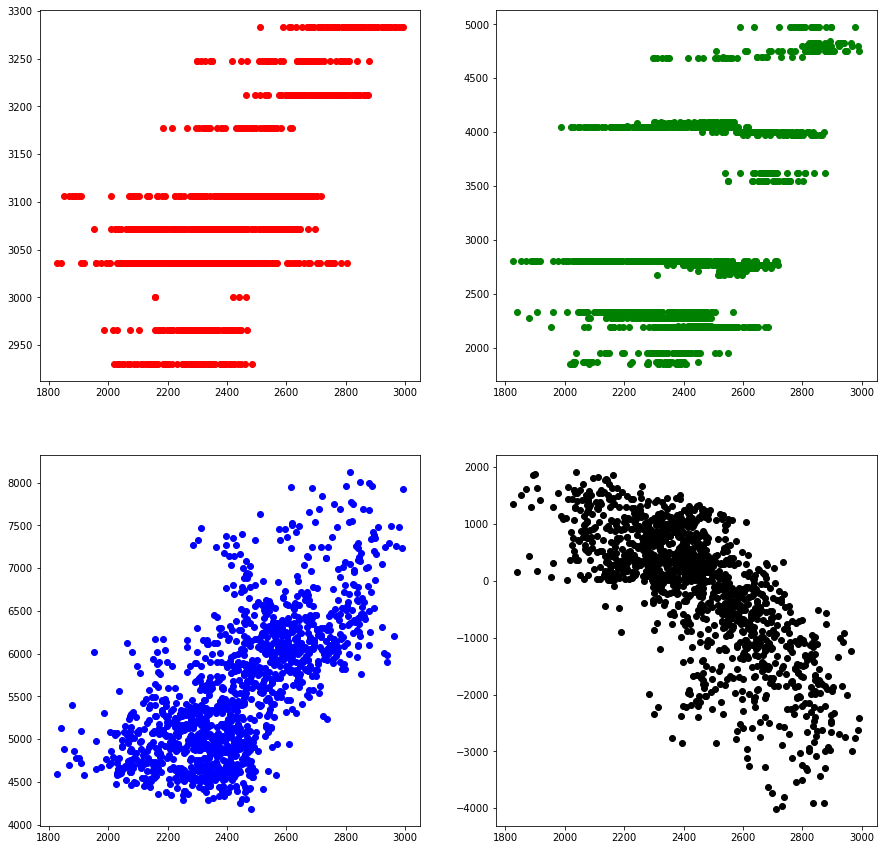

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0, 0].scatter(df_final['AB_BC_BORDER'], df_final['OSDA'], color='r') #row=0, col=0
ax[1, 0].scatter(df_final['AB_BC_BORDER'], df_final['INTRAPROVINCIAL'], color='b') #row=1, col=0
ax[0, 1].scatter(df_final['AB_BC_BORDER'], df_final['CONTRACT_DEMAND_x'], color='g') #row=0, col=1
ax[1, 1].scatter(df_final['AB_BC_BORDER'], df_final['TOTAL_NET_STORAGE'], color='k') #row=1, col=1
plt.show()

**before we jump into forecasting, let's take care of the future gas prices in Df8**

In [ ]:
df8.dropna(axis=0, inplace=True)

In [ ]:
df8.head()

,TRADE_DATE,HUB,PRODUCT,STRIP,CONTRACT_MONTH,CONTRACT_YEAR,CONTRACT,CONTRACT_TYPE,SETTLEMENT_PRICE,NET_CHANGE,EXPIRY_DATE,PRODUCT_ID,PUBLISH_DATE,DATE_INSERTED
0,2022-03-01 0:00,AB-NIT,NG NGX 7a Futures (US/MM),2022-03-01,3,2022,FQN,F,3.7296,-0.0009,2022-03-02 0:00,1959-06-24 0:00,2022-03-01 0:00,2022-03-01 15:46
1,2022-03-01 0:00,AB-NIT,NG NGX 7a Futures (US/MM),2022-04-01,4,2022,FQN,F,3.5580,0.1310,2022-04-04 0:00,1959-06-24 0:00,2022-03-01 0:00,2022-03-01 15:46
2,2022-03-01 0:00,AB-NIT,NG NGX 7a Futures (US/MM),2022-05-01,5,2022,FQN,F,3.5230,0.1530,2022-05-03 0:00,1959-06-24 0:00,2022-03-01 0:00,2022-03-01 15:46
3,2022-03-01 0:00,AB-NIT,NG NGX 7a Futures (US/MM),2022-06-01,6,2022,FQN,F,3.5150,0.1590,2022-06-02 0:00,1959-06-24 0:00,2022-03-01 0:00,2022-03-01 15:46
4,2022-03-01 0:00,AB-NIT,NG NGX 7a Futures (US/MM),2022-07-01,7,2022,FQN,F,3.5310,0.1550,2022-07-05 0:00,1959-06-24 0:00,2022-03-01 0:00,2022-03-01 15:46


In [ ]:
df8_ABNIT = df8[df8.HUB == 'AB-NIT']
df8_Ventura = df8[df8.HUB == 'Ventura']
df8_GTNMalin = df8[df8.HUB == 'GTN-Malin']
df8_UnionDawn = df8[df8.HUB == 'Union-Dawn']

In [ ]:
l = []

for i, df in enumerate([df8_ABNIT,df8_Ventura,df8_GTNMalin,df8_UnionDawn]):
  df_date = pd.DataFrame(pd.date_range(start=min(df.STRIP),end=max(df.STRIP)),columns = ['date'])
  df_date_1 = pd.merge(df_date,df,left_on='date', right_on='STRIP',how='left')
  df_date_1.fillna(method='ffill', inplace=True)
  df_date_1 = df_date_1[(df_date_1.date > '2022-03-01') & (df_date_1.date <= '2023-03-01')]
  df_date_1.index = df_date_1['date']
  
  l.append(df_date_1[['SETTLEMENT_PRICE','HUB']])



# df_date_1 = pd.merge(df_date,df6,left_on='date', right_on='OPR_DATE',how='left')



In [ ]:
l_ABNIT = l[0][['SETTLEMENT_PRICE']]
l_ABNIT.columns = ['AB_NIT_SD_2A']

l_Ventura_DA = l[1][['SETTLEMENT_PRICE']]
l_Ventura_DA.columns = ['Ventura_DA']

l_Malin_DA = l[2][['SETTLEMENT_PRICE']]
l_Malin_DA.columns = ['Malin_DA']

l_Union_Dawn_DA = l[3][['SETTLEMENT_PRICE']]
l_Union_Dawn_DA.columns = ['Union_Dawn_DA']

In [ ]:
df_hist

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,Empress_DA
2016-01-01,2.6400,2.4764,1.7269,0.000,0.0000
2016-01-02,2.6400,2.4764,1.6464,0.000,0.0000
2016-01-03,2.6400,2.4764,1.7236,0.000,0.0000
2016-01-04,2.6400,2.4764,1.7647,0.000,0.0000
2016-01-05,2.5185,2.5386,1.7262,0.000,0.0000
...,...,...,...,...,...
2022-04-26,4.0761,4.3815,3.7278,5.175,0.0986
2022-04-27,4.0761,4.3815,3.7278,5.175,0.0986
2022-04-28,4.0761,4.3815,3.7278,5.175,0.0986
2022-04-29,4.0761,4.3815,3.7278,5.175,0.0986


In [ ]:
da =df_hist[(df_hist.index >= '2022-03-02') & (df_hist.index <= '2022-04-30')][['Union_Dawn_DA']]
l_Union_Dawn_DA = pd.concat([da,l_Union_Dawn_DA[(l_Union_Dawn_DA.index > '2022-04-30')]])

da =df_hist[(df_hist.index >= '2022-03-02') & (df_hist.index <= '2022-04-30')][['Malin_DA']]
l_Malin_DA = pd.concat([da,l_Malin_DA[(l_Malin_DA.index > '2022-04-30')]])

da =df_hist[(df_hist.index >= '2022-03-02') & (df_hist.index <= '2022-04-30')][['Ventura_DA']]
l_Ventura_DA = pd.concat([da,l_Ventura_DA[(l_Ventura_DA.index > '2022-04-30')]])

da =df_hist[(df_hist.index >= '2022-03-02') & (df_hist.index <= '2022-04-30')][['AB_NIT_SD_2A']]
l_ABNIT = pd.concat([da,l_ABNIT[(l_ABNIT.index > '2022-04-30')]])

In [ ]:
Future_prices = pd.concat([l_Malin_DA,l_Union_Dawn_DA,l_ABNIT,l_Ventura_DA], axis=1)

In [ ]:
Future_prices

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA
2022-03-02,4.0761,4.3815,3.9395,5.1750
2022-03-03,4.2454,4.5988,3.7278,5.1750
2022-03-04,4.0761,4.3815,3.7278,5.1750
2022-03-05,4.0761,4.3815,3.7278,5.1750
2022-03-06,4.0761,4.3815,3.7278,5.1750
...,...,...,...,...
2023-02-25,5.4195,4.7645,3.8520,5.3695
2023-02-26,5.4195,4.7645,3.8520,5.3695
2023-02-27,5.4195,4.7645,3.8520,5.3695
2023-02-28,5.4195,4.7645,3.8520,5.3695


In [ ]:
df3_future =df3[(df3.index >= '2022-03-02') & (df3.index <= '2023-03-01')][['CONTRACT_DEMAND']]
df3_future.columns = ['CONTRACT_DEMAND_x']

In [ ]:
df_NGTL_future = df_NGTL[(df_NGTL.index >= '2022-03-02') & (df_NGTL.index <= '2023-03-01')]
df_NGTL_future.columns = ['EGAT_x','OSDA','NEDA','LCLR','FHZ9','LCLD','USJR','WGAT']

df_FX_future = df_FX[(df_FX.index >= '2022-03-02') & (df_FX.index <= '2023-03-01')][['USD_MID']]

In [ ]:
df_future_int = pd.concat([Future_prices,df3_future, df_NGTL_future, df_FX_future], axis=1)

In [ ]:
df_future_int

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,CONTRACT_DEMAND_x,EGAT_x,OSDA,NEDA,LCLR,FHZ9,LCLD,USJR,WGAT,USD_MID
2022-03-02,4.0761,4.3815,3.9395,5.1750,4972.820197,5118.639473,3247.688493,0.0,0.0,0.0,0.0,11861.12319,2894.678874,1.274150
2022-03-03,4.2454,4.5988,3.7278,5.1750,4972.820197,5118.639473,3247.688493,0.0,0.0,0.0,0.0,11861.12319,2894.678874,1.274150
2022-03-04,4.0761,4.3815,3.7278,5.1750,4972.820197,5118.639473,3247.688493,0.0,0.0,0.0,0.0,11861.12319,2894.678874,1.274150
2022-03-05,4.0761,4.3815,3.7278,5.1750,4972.820197,5118.639473,3247.688493,0.0,0.0,0.0,0.0,11861.12319,2894.678874,1.274150
2022-03-06,4.0761,4.3815,3.7278,5.1750,4972.820197,4871.532740,3247.688493,0.0,0.0,0.0,0.0,11614.01646,2824.076950,1.274150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25,5.4195,4.7645,3.8520,5.3695,4452.304054,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836,1.275578
2023-02-26,5.4195,4.7645,3.8520,5.3695,4452.304054,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836,1.275578
2023-02-27,5.4195,4.7645,3.8520,5.3695,4452.304054,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836,1.275578
2023-02-28,5.4195,4.7645,3.8520,5.3695,4452.304054,5471.649091,3247.688493,0.0,0.0,0.0,0.0,12496.54051,2929.979836,1.275578


In [ ]:
features = ['Malin_DA','Union_Dawn_DA', 'AB_NIT_SD_2A','Ventura_DA', 'CONTRACT_DEMAND_x', 'EGAT_x', 'OSDA','NEDA','LCLR','FHZ9','LCLD','USJR','WGAT','USD_MID']

In [ ]:
df_Intergrated = pd.concat([df_final[features],df_future_int ], axis=0)

# Attention!

**No we have the full dataset containg the historical and the one year after 2022-03-01 to forecast.
but before we do that, we need to make our model understand the continuity of the records and that a day comes after another so we can make our model understand that this is a time series data.**

In [ ]:
def fourier(df, year):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
    sine and 1 for cosine)
    """
    
    for k in range(1, year+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)
    

In [ ]:
fourier(df_Intergrated, year= 2)

**Let's split the whoe datset into train/test and forecast parts.**

In [ ]:
featuress = ['NEDA','LCLR','FHZ9','LCLD']

In [ ]:
df_train = df_Intergrated[df_Intergrated.index < '2022-03-02']
df_forecast = df_Intergrated[df_Intergrated.index >= '2022-03-02']
df_train = pd.concat([df_train, df2[df2.index >= '2018-07-13'][['AB_BC_BORDER']]], axis = 1)
df_train = df_train.drop(featuress, axis = 1)
df_forecast = df_forecast.drop(featuress, axis = 1)

In [ ]:
df_train['Union_Dawn_DA'] = df_train['Union_Dawn_DA'].apply(math.log2)
df_train['Malin_DA'] = df_train['Malin_DA'].apply(math.log2)
df_train['Ventura_DA'] = df_train['Ventura_DA'].apply(math.log2)

In [ ]:
df_train

In [ ]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,CONTRACT_DEMAND_x,EGAT_x,OSDA,USJR,WGAT,USD_MID,year_sin1,year_cos1,year_sin2,year_cos2,AB_BC_BORDER
Malin_DA,1.000000,0.848048,0.610833,0.640550,0.447809,0.026014,0.266871,-0.033045,0.168839,-0.541377,-0.196908,0.468551,0.033984,0.102905,0.347390
Union_Dawn_DA,0.848048,1.000000,0.571287,0.635112,0.453940,-0.049000,0.214028,-0.163597,0.113941,-0.608329,-0.202500,0.274881,-0.006016,0.043429,0.247817
AB_NIT_SD_2A,0.610833,0.571287,1.000000,0.744625,0.783619,0.378884,0.323066,0.337648,0.544777,-0.591133,0.032954,0.300577,-0.030023,0.052014,0.407883
Ventura_DA,0.640550,0.635112,0.744625,1.000000,0.644449,0.258382,0.319749,0.286396,0.478017,-0.507944,0.010088,0.362750,-0.014948,0.072944,0.385786
CONTRACT_DEMAND_x,0.447809,0.453940,0.783619,0.644449,1.000000,0.501449,0.390601,0.502347,0.579398,-0.667510,0.128712,0.207235,-0.025179,0.126876,0.445545
EGAT_x,0.026014,-0.049000,0.378884,0.258382,0.501449,1.000000,0.246915,0.509080,0.458344,-0.188426,0.217464,0.065247,0.033871,0.318257,0.282761
OSDA,0.266871,0.214028,0.323066,0.319749,0.390601,0.246915,1.000000,0.382280,0.447769,-0.093672,0.267333,0.649887,0.022600,0.086120,0.680764
USJR,-0.033045,-0.163597,0.337648,0.286396,0.502347,0.509080,0.382280,1.000000,0.476418,0.033136,0.374008,0.296377,-0.100586,0.190558,0.340295
WGAT,0.168839,0.113941,0.544777,0.478017,0.579398,0.458344,0.447769,0.476418,1.000000,-0.234015,0.229153,0.346642,-0.014953,0.236116,0.596333
USD_MID,-0.541377,-0.608329,-0.591133,-0.507944,-0.667510,-0.188426,-0.093672,0.033136,-0.234015,1.000000,0.141807,-0.078047,-0.051148,-0.101125,-0.282124


In [ ]:
import math

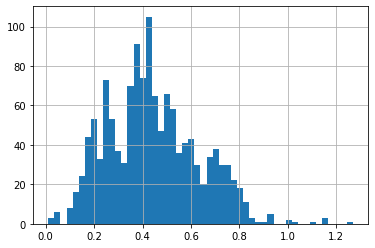

In [ ]:
df_train['Malin_DA'].apply(math.log10).hist(bins=50)

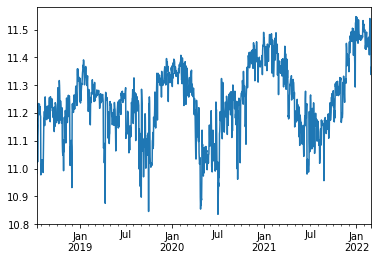

In [ ]:
df_train['AB_BC_BORDER'].apply(math.log2).plot()

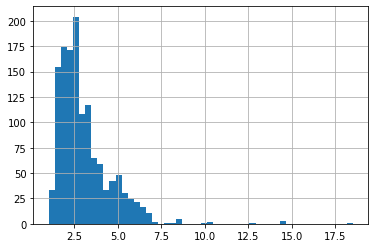

In [ ]:
(df_train['Malin_DA']).hist(bins=50)

In [ ]:
df_train.columns

Index(['Malin_DA', 'Union_Dawn_DA', 'AB_NIT_SD_2A', 'Ventura_DA',
       'CONTRACT_DEMAND_x', 'EGAT_x', 'OSDA', 'USJR', 'WGAT', 'USD_MID',
       'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'AB_BC_BORDER'],
      dtype='object')

In [ ]:
cols_to_norm = ['CONTRACT_DEMAND_x', 'EGAT_x', 'OSDA', 'USJR', 'WGAT']
df_train[cols_to_norm] = StandardScaler().fit_transform(df_train[cols_to_norm])

In [ ]:
df_train

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,CONTRACT_DEMAND_x,EGAT_x,WGAT,USD_MID,year_sin1,year_cos1,year_sin2,year_cos2,AB_BC_BORDER
2018-07-13,0.407187,0.438653,1.1011,0.262451,1846.047420,4765.629854,2329.863484,1.31695,-0.194431,-0.980916,0.381441,0.924393,2024
2018-07-14,0.408308,0.433338,0.7502,0.262451,1846.047420,4765.629854,2329.863484,1.31695,-0.211276,-0.977426,0.413013,0.910725,2313
2018-07-15,0.408308,0.433338,0.7630,0.262451,1846.047420,4765.629854,2329.863484,1.31695,-0.228058,-0.973648,0.444096,0.895979,2317
2018-07-16,0.408308,0.433338,0.7082,0.190332,1846.047420,4765.629854,2329.863484,1.31310,-0.244772,-0.969581,0.474653,0.880173,2281
2018-07-17,0.406234,0.438242,0.9571,0.211307,1846.047420,4765.629854,2329.863484,1.31980,-0.261414,-0.965227,0.504648,0.863325,2082
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,0.734320,0.680924,3.7896,0.713910,4972.820197,5118.639473,2894.678874,1.27440,0.821100,0.570784,0.937342,-0.348411,2855
2022-02-26,0.638819,0.651637,3.7532,0.713910,4972.820197,5118.639473,2894.678874,1.27440,0.830797,0.556576,0.924803,-0.380447,2843
2022-02-27,0.638819,0.651637,3.6640,0.713910,4972.820197,5118.639473,2894.678874,1.27440,0.840248,0.542202,0.911169,-0.412034,2809
2022-02-28,0.638819,0.651637,3.7244,0.713910,4972.820197,5118.639473,2894.678874,1.26620,0.849450,0.527668,0.896456,-0.443132,2589


In [ ]:
def train_test(data, test_size = 0.15):
    """
         train-test split with respect to time series structure
        
        - data: dataframe with variables X_n to train on and the dependent output y which is the column 'Gas Flow'
        - test_size: size of test set
    """
    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
        
    X_train = df.drop('AB_BC_BORDER', axis = 1).iloc[:test_index]
    y_train = df.AB_BC_BORDER.iloc[:test_index]
    X_test = df.drop('AB_BC_BORDER', axis = 1).iloc[test_index:]
    y_test = df.AB_BC_BORDER.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
df_train

In [ ]:
X_train, X_test, y_train, y_test = train_test(df_train, test_size=0.15)
# X_train = Sc.fit_transform(X_train)
# X_test = Sc.fit_transform(X_test)

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.155,
                max_depth = 3, alpha = 4, n_estimators = 150, random_state=42, reg_lambda=1.05)

In [ ]:
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=4, colsample_bytree=0.4, learning_rate=0.155,
             n_estimators=150, objective='reg:squarederror', random_state=42,
             reg_lambda=1.05)

In [ ]:
dfdf_train_ = metrics(xg_reg.predict(X_train), y_train)

RMSE or Root mean squared error: 0.01
R2 score: 0.93
Mean Absolute Error: 0.01


In [ ]:
preds_boost = xg_reg.predict(X_test)
_ = metrics(preds_boost, y_test)

RMSE or Root mean squared error: 0.02
R2 score: 0.64
Mean Absolute Error: 0.02


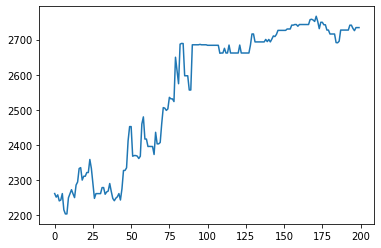

In [ ]:
plt.plot(preds_boost)

In [ ]:
plot_ts_pred(y_train, xg_reg.predict(X_train), model_name='XGBoost with Fourier terms on Training set')

In [ ]:
df_Concatt = pd.concat([df_train, df_forecast])

In [ ]:
df_forecast

In [ ]:
preds_boost = xg_reg.predict(df_forecast)

In [ ]:
df_fcst = pd.DataFrame(preds_boost, columns=['Predictions'])

In [ ]:
df_fcst.index = df_forecast.index

In [ ]:
df_fcst

,Predictions
2022-03-02,2825.747314
2022-03-03,2825.747314
2022-03-04,2825.747314
2022-03-05,2825.747314
2022-03-06,2693.875732
...,...
2023-02-25,2697.910156
2023-02-26,2692.535400
2023-02-27,2707.969238
2023-02-28,2719.577393


In [ ]:
from google.colab import files

df_fcst.to_csv('df.csv')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_Concatt['AB_BC_BORDER']

2018-07-13    2024.0
2018-07-14    2313.0
2018-07-15    2317.0
2018-07-16    2281.0
2018-07-17    2082.0
               ...  
2023-02-25       NaN
2023-02-26       NaN
2023-02-27       NaN
2023-02-28       NaN
2023-03-01       NaN
Name: AB_BC_BORDER, Length: 1693, dtype: float64

In [ ]:
plot_ts_pred(df_Concatt['AB_BC_BORDER'], xg_reg.predict(df_Concatt.drop('AB_BC_BORDER', axis = 1)), model_name='XGBoost with Fourier terms')

In [ ]:
!pip install -q git+https://github.com/google/lifetime_value
import lifetime_value as ltv

     |████████████████████████████████| 462 kB 4.4 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import tqdm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from typing import Sequence

In [ ]:
LOSS = 'mse'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln','mse']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}

In [ ]:
df_train

,Malin_DA,Union_Dawn_DA,AB_NIT_SD_2A,Ventura_DA,CONTRACT_DEMAND_x,EGAT_x,OSDA,USJR,WGAT,USD_MID,year_sin1,year_cos1,year_sin2,year_cos2,AB_BC_BORDER
2018-07-13,2.5538,2.7457,1.1011,1.8300,1846.047420,4765.629854,3071.183684,10060.77414,2329.863484,1.31695,-0.194431,-0.980916,0.381441,0.924393,2024
2018-07-14,2.5604,2.7123,0.7502,1.8300,1846.047420,4765.629854,3071.183684,10060.77414,2329.863484,1.31695,-0.211276,-0.977426,0.413013,0.910725,2313
2018-07-15,2.5604,2.7123,0.7630,1.8300,1846.047420,4765.629854,3071.183684,10060.77414,2329.863484,1.31695,-0.228058,-0.973648,0.444096,0.895979,2317
2018-07-16,2.5604,2.7123,0.7082,1.5500,1846.047420,4765.629854,3071.183684,10060.77414,2329.863484,1.31310,-0.244772,-0.969581,0.474653,0.880173,2281
2018-07-17,2.5482,2.7431,0.9571,1.6267,1846.047420,4765.629854,3071.183684,10060.77414,2329.863484,1.31980,-0.261414,-0.965227,0.504648,0.863325,2082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,5.4240,4.7965,3.7896,5.1750,4972.820197,5118.639473,3282.989455,11861.12319,2894.678874,1.27440,0.821100,0.570784,0.937342,-0.348411,2855
2022-02-26,4.3533,4.4837,3.7532,5.1750,4972.820197,5118.639473,3282.989455,11861.12319,2894.678874,1.27440,0.830797,0.556576,0.924803,-0.380447,2843
2022-02-27,4.3533,4.4837,3.6640,5.1750,4972.820197,5118.639473,3282.989455,11861.12319,2894.678874,1.27440,0.840248,0.542202,0.911169,-0.412034,2809
2022-02-28,4.3533,4.4837,3.7244,5.1750,4972.820197,5118.639473,3282.989455,11861.12319,2894.678874,1.26620,0.849450,0.527668,0.896456,-0.443132,2589


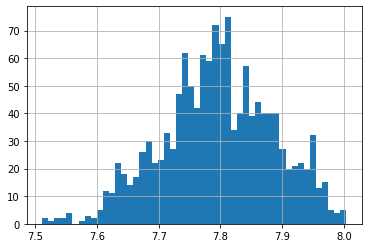

In [ ]:
df_train.AB_BC_BORDER.apply(np.log1p).hist(bins=50)

In [ ]:
X_train, X_test, y_train, y_test = train_test(df_train, test_size=0.15)

In [ ]:
X_train.shape

(1128, 14)

In [ ]:
def feature_dict(df):
  features = {k: v.values for k, v in dict(df).items()}
  return features

In [ ]:
x_train, y_train = feature_dict(X_train), y_train.values
x_eval, y_eval = feature_dict(X_test), y_test.values

In [ ]:
len(x_train['AB_NIT_SD_2A'])

1128

In [ ]:
def dnn_model(output_units, df):

  # numeric_input = tf.keras.layers.Input(
  #     shape=(len(df.columns),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in df.columns
  ]

  deep_input = tf.keras.layers.concatenate(embedding_inputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[embedding_inputs] , outputs=deep_model(deep_input))

In [ ]:
if LOSS == 'mse':
  loss = keras.losses.MeanSquaredError()
  output_units = 1
  
if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [ ]:
if MODEL == 'dnn':
  model = dnn_model(output_units, df_train.drop('AB_BC_BORDER', axis = 1))

In [ ]:
model.summary()

In [ ]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [ ]:
  y_train = y_train.astype('float32')
  y_eval = y_eval.astype('float32')

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

In [ ]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

In [ ]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=32).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

In [ ]:
_ = metrics(y_pred, y_eval)

RMSE or Root mean squared error: 154.83
R2 score: 0.58
Mean Absolute Error: 115.75


In [ ]:
df_pred = pd.DataFrame({
    'y_true': y_eval,
    'y_pred': y_pred,
})
df_pred.head(10)

,y_true,y_pred
0,2213.0,2306.208252
1,2312.0,2371.446777
2,2280.0,2371.446777
3,2306.0,2323.690918
4,2288.0,2288.089111
5,2281.0,2288.089111
6,2292.0,2284.362305
7,2287.0,2385.356689
8,2292.0,2385.356689
9,2248.0,2416.857666


In [ ]:
X_train, X_test, y_train, y_test = train_test(df_train, test_size=0.15)

In [ ]:
X_train.values

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from keras.layers import Bidirectional

In [ ]:
inputs = torch.from_numpy(X_train.values).float()
targets = torch.from_numpy(y_train.values).float()

In [ ]:
print(inputs)

tensor([[ 2.5538,  2.7457,  1.1011,  ..., -0.9809,  0.3814,  0.9244],
        [ 2.5604,  2.7123,  0.7502,  ..., -0.9774,  0.4130,  0.9107],
        [ 2.5604,  2.7123,  0.7630,  ..., -0.9736,  0.4441,  0.8960],
        ...,
        [ 4.0935,  3.9786,  1.4274,  ..., -0.7683,  0.9835,  0.1807],
        [ 4.0620,  3.8793,  2.3016,  ..., -0.7572,  0.9892,  0.1468],
        [ 4.0000,  3.8530,  2.5460,  ..., -0.7459,  0.9936,  0.1127]])


In [ ]:
dataset = TensorDataset(inputs, targets)
batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
inputs.shape[1]

14

In [ ]:
inputs.T.shape

torch.Size([14, 1128])

In [ ]:
class LinearR(nn.Module):
  def __init__(self):
    super().__init__()
    # self.w = nn.Parameter(torch.randn(inputs.shape[1] , requires_grad=True, dtype=torch.double))
    # self.b = nn.Parameter(torch.randn(14 , requires_grad=True, dtype=torch.double))
    self.linear = nn.Linear(14, 1,dtype=torch.float)
    
  def forward(self,x):
    return self.linear(x)

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
model = LinearR()
lr = 1e-6
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr = lr)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
for epoch in range(n_epochs):
  for x, y in train_loader:
    model.train()
    
    yhat = model(x)
    
    loss = loss_fn(y, yhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch {epoch}/{n_epochs}: Loss: {torch.sqrt(loss)}")
  # scheduler.step()


In [ ]:
X_train, X_test, y_train, y_test = train_test(df_train, test_size=0.15)

In [ ]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3  # Number of past days we want to use to predict the future.
trainX = []
trainY = []
testX = []
testY = []

In [ ]:
# X_train = X_train.iloc[:10,:]

In [ ]:
# y_train = y_train[:10]

In [ ]:
for i in range(n_past, len(X_train) - n_future +1):
    trainX.append(X_train.iloc[i - n_past:i, 0:X_train.shape[1]])
    trainY.append(y_train.iloc[i + n_future - 1:i + n_future])

for i in range(n_past, len(X_test) - n_future +1):
    testX.append(X_test.iloc[i - n_past:i, 0:X_test.shape[1]])
    testY.append(y_test.iloc[i + n_future - 1:i + n_future])

In [ ]:
y_train

2018-07-13    2024
2018-07-14    2313
2018-07-15    2317
2018-07-16    2281
2018-07-17    2082
              ... 
2021-08-09    2102
2021-08-10    2185
2021-08-11    2181
2021-08-12    2262
2021-08-13    2171
Name: AB_BC_BORDER, Length: 1128, dtype: int64

In [ ]:
trainY

[2018-07-16    2281
 Name: AB_BC_BORDER, dtype: int64, 2018-07-17    2082
 Name: AB_BC_BORDER, dtype: int64, 2018-07-18    2219
 Name: AB_BC_BORDER, dtype: int64, 2018-07-19    2277
 Name: AB_BC_BORDER, dtype: int64, 2018-07-20    2409
 Name: AB_BC_BORDER, dtype: int64, 2018-07-21    2381
 Name: AB_BC_BORDER, dtype: int64, 2018-07-22    2350
 Name: AB_BC_BORDER, dtype: int64]

In [ ]:
trainX

In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [ ]:
trainX.shape

(1125, 3, 14)

In [ ]:
trainY.shape

(1125, 1)

In [ ]:
import tensorflow as tf


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(20, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
model.add(Bidirectional(LSTM(20, activation='relu', return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(20, activation='relu', return_sequences=False)))
model.add(Dense(trainY.shape[1]))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse')


In [ ]:
input_shape = trainX.shape  
model.build(input_shape) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (1125, 3, 40)            5600      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (1125, 3, 40)            9760      
 nal)                                                            
                                                                 
 dropout (Dropout)           (1125, 3, 40)             0         
                                                                 
 bidirectional_2 (Bidirectio  (1125, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (1125, 1)                 41        
                                                      

In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/100
141/141 [==============================] - 9s 14ms/step - loss: 3326273.2500 - val_loss: 120832.2812
Epoch 2/100
141/141 [==============================] - 1s 8ms/step - loss: 167940.8594 - val_loss: 96950.3125
Epoch 3/100
141/141 [==============================] - 1s 8ms/step - loss: 108111.4688 - val_loss: 146096.0469
Epoch 4/100
141/141 [==============================] - 1s 8ms/step - loss: 97217.5234 - val_loss: 120128.8828
Epoch 5/100
141/141 [==============================] - 1s 8ms/step - loss: 90600.6406 - val_loss: 100422.9844
Epoch 6/100
141/141 [==============================] - 1s 8ms/step - loss: 86740.0781 - val_loss: 72725.9609
Epoch 7/100
141/141 [==============================] - 1s 8ms/step - loss: 75288.8438 - val_loss: 104478.5078
Epoch 8/100
141/141 [==============================] - 1s 8ms/step - loss: 73910.0469 - val_loss: 158060.8594
Epoch 9/100
141/141 [==============================] - 1s 8ms/step - loss: 60204.7656 - val_loss: 134626.9531
Epoch 1

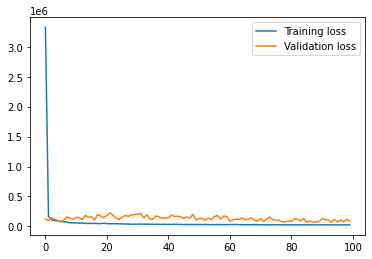

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
dfdf_train_ = metrics(model.predict(trainX), trainY)

RMSE or Root mean squared error: 283.18
R2 score: -1.01
Mean Absolute Error: 254.00


In [ ]:
testY

In [ ]:
y_test.head(30)

In [ ]:
model.predict(testX)

array([[2146.2869],
       [2120.099 ],
       [2100.0063],
       [2083.36  ],
       [2077.4097],
       [2071.0745],
       [2065.5513],
       [2125.737 ],
       [2174.2185],
       [2214.458 ],
       [2178.364 ],
       [2171.3867],
       [2203.5793],
       [2247.403 ],
       [2275.3003],
       [2275.322 ],
       [2213.946 ],
       [2166.6543],
       [2126.644 ],
       [2116.1462],
       [2108.5188],
       [2162.3716],
       [2226.0525],
       [2221.8955],
       [2189.7075],
       [2154.2158],
       [2154.7896],
       [2155.1814],
       [2155.5002],
       [2155.9285],
       [2156.811 ],
       [2157.3398],
       [2157.5325],
       [2157.2954],
       [2156.3813],
       [2155.8086],
       [2125.413 ],
       [2102.042 ],
       [2112.3271],
       [2135.4   ],
       [2154.8203],
       [2154.3745],
       [2191.2954],
       [2220.7886],
       [2245.68  ],
       [2246.249 ],
       [2266.5925],
       [2300.1228],
       [2327.2144],
       [2254.3257],
